# Datos y librerías

In [3]:
!gdown --id 1gzRqjQzPPlxfy2CcBmqaPgy29F_wnBkL -O pobreza_pob.csv
!gdown --id 1PNzMGvdMsMtQQ_pqdSMRQDamArfrFYsL -O ic_sbv_pob.csv
import pandas as pd
df_pobreza = pd.read_csv('pobreza_pob.csv')
df_ic = pd.read_csv('ic_sbv_pob.csv')

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gzRqjQzPPlxfy2CcBmqaPgy29F_wnBkL
To: /content/pobreza_pob.csv
100% 517k/517k [00:00<00:00, 107MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PNzMGvdMsMtQQ_pqdSMRQDamArfrFYsL
To: /content/ic_sbv_pob.csv
100% 516k/516k [00:00<00:00, 35.0MB/s]


In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


# pobreza_pob

## SVR

### Test Train values

In [7]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 0.6137045720553735
MSE: 0.007067559826950046

Métricas en el conjunto de test:
R²: 0.6215445659967336
MSE: 0.0073444865316701115


### Cross-Validation

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(svr_model, X, y, cv=10, scoring=scoring)


mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)



Resultados de Validación Cruzada (K = 10 folds)
R² Promedio: 0.3395996458774929
MSE Promedio: 0.009946062842256475


### Ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict

X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)



param_distributions = {
    'C': np.logspace(-2, 2, 50),
    'epsilon': np.linspace(0.001, 1, 50),
    'gamma': ['scale', 'auto']
}


random_search = RandomizedSearchCV(
    estimator=SVR(kernel='rbf'),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)




best_params = random_search.best_params_


C_best = best_params['C']
epsilon_best = best_params['epsilon']
gamma_best = best_params['gamma']

param_grid = {
    'C': [C_best * 0.5, C_best, C_best * 1.5],
    'epsilon': [epsilon_best * 0.5, epsilon_best, epsilon_best * 1.5],
    'gamma': [gamma_best]
}


grid_search = GridSearchCV(
    estimator=SVR(kernel='rbf'),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)


grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


=== Randomized Search ===
Mejores hiperparámetros encontrados: {'gamma': 'scale', 'epsilon': 0.041775510204081635, 'C': 2.329951810515372}
Mejor Score (MSE negativo): -0.006070625507687952

=== Grid Search ===
Mejores hiperparámetros encontrados: {'C': 3.4949277157730583, 'epsilon': 0.020887755102040818, 'gamma': 'scale'}
Mejor Score (MSE negativo): -0.006017446275329666


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_

y_pred = cross_val_predict(best_model, X, y, cv=cv)

final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


=== Evaluación Final del Modelo ===
R²: 0.663394499822437
MSE: 0.006017120856727691


### Test-train después del ajuste

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svr_model = SVR(kernel='rbf',
                C=3.4949277157730583,
                epsilon=0.020887755102040818,
                gamma='scale')


svr_model.fit(X_train, y_train)

y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


Métricas en el conjunto de entrenamiento:
R²: 0.6702888100010014
MSE: 0.0060809762595726916

Métricas en el conjunto de test:
R²: 0.7181798666730973
MSE: 0.004396300720727193


## Gradient Boosting

### Test Train values

In [ ]:

X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


Métricas en el conjunto de entrenamiento:
R²: 0.9019060539616112
MSE: 0.0018091802012211331

Métricas en el conjunto de test:
R²: 0.6566740728082154
MSE: 0.005355770729860377


### Cross-Validation

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

gb_model = GradientBoostingRegressor(random_state=42)

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(gb_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)



Resultados de Validación Cruzada (K = 10 folds)
R² Promedio: 0.5838774026891002
MSE Promedio: 0.006899033482949383


### Ajuste de hiperparámetros

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]


cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 4, 6]
}

random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=5,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)



best_params = random_search.best_params_

n_estimators_best = best_params['n_estimators']
learning_rate_best = best_params['learning_rate']
max_depth_best = best_params['max_depth']
subsample_best = best_params['subsample']
min_samples_split_best = best_params['min_samples_split']

param_grid = {
    'n_estimators': [max(50, n_estimators_best - 50), n_estimators_best, n_estimators_best + 50],
    'learning_rate': [learning_rate_best * 0.8, learning_rate_best, learning_rate_best * 1.2],
    'max_depth': [max(1, max_depth_best - 1), max_depth_best, max_depth_best + 1],
    'subsample': [max(0.6, subsample_best - 0.1), subsample_best, min(1.0, subsample_best + 0.1)],
    'min_samples_split': [max(2, min_samples_split_best - 1), min_samples_split_best, min_samples_split_best + 1]
}


grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)


grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)

=== Randomized Search ===
Mejores hiperparámetros encontrados: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 3, 'learning_rate': 0.16263157894736843}
Mejor Score (MSE negativo): -0.006869511097473124

=== Grid Search ===
Mejores hiperparámetros encontrados: {'learning_rate': 0.13010526315789475, 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 50, 'subsample': 0.9}
Mejor Score (MSE negativo): -0.006295873981124864


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_


y_pred = cross_val_predict(best_model, X, y, cv=cv)

final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)



=== Evaluación Final del Modelo ===
R²: 0.6477958824619011
MSE: 0.006295959930381224


### Test-train después del ajuste

In [ ]:

X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)

gb_model.fit(X_train, y_train)


y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 0.9774696137346243
MSE: 0.0004155356207327048

Métricas en el conjunto de test:
R²: 0.6124860145577624
MSE: 0.006045089800292655


## Regresión Lineal

### Antes de optimización y validación cruzada

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)


r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 0.6165033094655751
MSE: 0.00729552699802785

Métricas en el conjunto de test:
R²: 0.7746701821369734
MSE: 0.0034222693334729974


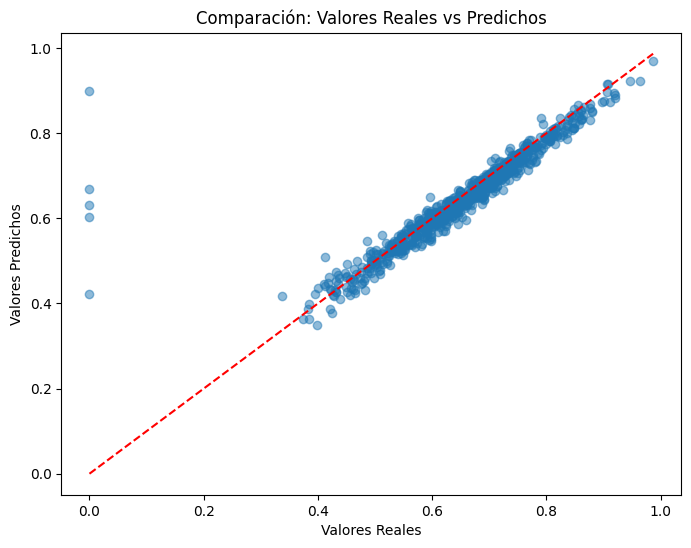

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación: Valores Reales vs Predichos')
plt.show()

### Validación Cruzada

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

lr_model = LinearRegression()


scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}


cv_results_train = cross_validate(lr_model, X_train, y_train, cv = 10, scoring = scoring)
cv_results_test = cross_validate(lr_model, X_test, y_test, cv = 10, scoring = scoring)


mean_r2_train = np.mean(cv_results_train['test_r2'])
mean_mse_train = -np.mean(cv_results_train['test_mse'])

print("Resultados de Validación Cruzada en conjunto de entrenamiento (K = 10 folds)")
print("R² Promedio:", mean_r2_train)
print("MSE Promedio:", mean_mse_train)


mean_r2_test = np.mean(cv_results_test['test_r2'])
mean_mse_test = -np.mean(cv_results_test['test_mse'])

print("\nResultados de Validación Cruzada en conjunto de prueba (K = 10 folds)")
print("R² Promedio:", mean_r2_test)
print("MSE Promedio:", mean_mse_test)

Resultados de Validación Cruzada en conjunto de entrenamiento (K = 10 folds)
R² Promedio: 0.6281497319543392
MSE Promedio: 0.007388943090936163

Resultados de Validación Cruzada en conjunto de prueba (K = 10 folds)
R² Promedio: 0.8172824576069445
MSE Promedio: 0.0033584239195320236


### Ajuste de Hiperparámetros

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]


cv = KFold(n_splits=10, shuffle=True, random_state=42)


param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}



grid_search = GridSearchCV(
    estimator = LinearRegression(),
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = cv,
    n_jobs = -1
)

grid_search.fit(X, y)

print("=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)

=== Grid Search ===
Mejores hiperparámetros encontrados: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Mejor Score (MSE negativo): -0.006188310184381708


### Validación Cruzada después del ajuste

In [ ]:

best_model = grid_search.best_estimator_


y_train_pred = cross_val_predict(best_model, X_train, y_train, cv = cv)
y_test_pred = cross_val_predict(best_model, X_test, y_test, cv = cv)


final_r2_train = r2_score(y_train, y_train_pred)
final_mse_train = mean_squared_error(y_train, y_train_pred)


final_r2_test = r2_score(y_test, y_test_pred)
final_mse_test = mean_squared_error(y_test, y_test_pred)

print("=== Evaluación Final del Modelo en el conjunto de entrenamiento ===")
print("R²:", final_r2_train)
print("MSE:", final_mse_train)

print("\n=== Evaluación Final del Modelo en el conjunto de prueba ===")
print("R²:", final_r2_test)
print("MSE:", final_mse_test)

=== Evaluación Final del Modelo en el conjunto de entrenamiento ===
R²: 0.6099230823818067
MSE: 0.00742070728126807

=== Evaluación Final del Modelo en el conjunto de prueba ===
R²: 0.7771075697171812
MSE: 0.0033852507229373786


## Decision Tree

### Antes de ajuste y validación cruzada

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 1.0
MSE: 0.0

Métricas en el conjunto de test:
R²: 0.5442620507522558
MSE: 0.007109361034956724


### Validación Cruzada

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

dt_model = DecisionTreeRegressor()


scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}


cv_results_train = cross_validate(dt_model, X_train, y_train, cv = 10, scoring = scoring)
cv_results_test = cross_validate(dt_model, X_test, y_test, cv = 10, scoring = scoring)


mean_r2_train = np.mean(cv_results_train['test_r2'])
mean_mse_train = -np.mean(cv_results_train['test_mse'])

print("Resultados de Validación Cruzada en conjunto de entrenamiento (K = 10 folds)")
print("R² Promedio:", mean_r2_train)
print("MSE Promedio:", mean_mse_train)


mean_r2_test = np.mean(cv_results_test['test_r2'])
mean_mse_test = -np.mean(cv_results_test['test_mse'])

print("\nResultados de Validación Cruzada en conjunto de prueba (K = 10 folds)")
print("R² Promedio:", mean_r2_test)
print("MSE Promedio:", mean_mse_test)

Resultados de Validación Cruzada en conjunto de entrenamiento (K = 10 folds)
R² Promedio: 0.5958908240919676
MSE Promedio: 0.00831350765367318

Resultados de Validación Cruzada en conjunto de prueba (K = 10 folds)
R² Promedio: 0.3489336777709399
MSE Promedio: 0.009088853958655078


### Ajuste de Hiperparámetros

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

cv = KFold(n_splits = 10, shuffle = True, random_state = 42)


param_distributions = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['best', 'random']
}

random_search = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(random_state = 42),
    param_distributions = param_distributions,
    n_iter = 10,
    scoring = 'neg_mean_squared_error',
    cv = cv,
    random_state = 42,
    n_jobs = -1
)

random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)


best_params = random_search.best_params_

max_depth_best = best_params['max_depth']
min_samples_split_best = best_params['min_samples_split']
min_samples_leaf_best = best_params['min_samples_leaf']
max_features_best = best_params['max_features']
criterion_best = best_params['criterion']
splitter_best = best_params['splitter']

param_grid = {
    'max_depth': [max(1, max_depth_best - 1), max_depth_best, max_depth_best + 1],
    'min_samples_split': [max(2, min_samples_split_best - 1), min_samples_split_best, min_samples_split_best + 1],
    'min_samples_leaf': [max(1, min_samples_leaf_best - 1), min_samples_leaf_best, min_samples_leaf_best + 1],
    'max_features': [max_features_best, 'sqrt', 'log2', None],
    'criterion': [criterion_best, 'squared_error', 'friedman_mse'],
    'splitter': [splitter_best, 'best', 'random']
}

grid_search = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state = 42),
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = cv,
    n_jobs = -1
)

grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

=== Randomized Search ===
Mejores hiperparámetros encontrados: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'friedman_mse'}
Mejor Score (MSE negativo): -0.007015669102696751

=== Grid Search ===
Mejores hiperparámetros encontrados: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 11, 'splitter': 'random'}
Mejor Score (MSE negativo): -0.006803850624363608


### Validación Cruzada después del ajuste

In [ ]:

best_model = grid_search.best_estimator_


y_train_pred = cross_val_predict(best_model, X_train, y_train, cv = cv)
y_test_pred = cross_val_predict(best_model, X_test, y_test, cv = cv)


final_r2_train = r2_score(y_train, y_train_pred)
final_mse_train = mean_squared_error(y_train, y_train_pred)


final_r2_test = r2_score(y_test, y_test_pred)
final_mse_test = mean_squared_error(y_test, y_test_pred)

print("=== Evaluación Final del Modelo en el conjunto de entrenamiento ===")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\n=== Evaluación Final del Modelo en el conjunto de prueba ===")
print("R²:", r2_test)
print("MSE:", mse_test)

=== Evaluación Final del Modelo en el conjunto de entrenamiento ===
R²: 1.0
MSE: 0.0

=== Evaluación Final del Modelo en el conjunto de prueba ===
R²: 0.5442620507522558
MSE: 0.007109361034956724


## AdaBoost

### Test Train values

In [11]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost_model = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_model.fit(X_train, y_train)

y_train_pred = adaboost_model.predict(X_train)
y_test_pred = adaboost_model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 0.614189184873227
MSE: 0.007058693477945319

Métricas en el conjunto de test:
R²: 0.605576191660522
MSE: 0.007654376414884104


### Cross-Validation

In [12]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

adaboost_model = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, random_state=42)

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(adaboost_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)

Resultados de Validación Cruzada (K = 10 folds)
R² Promedio: 0.5306451190586456
MSE Promedio: 0.007720202361108075


### Ajuste de hiperparámetros

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)


param_distributions = {
    'n_estimators': np.arange(50, 501, 50),
    'learning_rate': np.linspace(0.01, 2, 50),
    'loss': ['linear', 'square', 'exponential']
}

random_search = RandomizedSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
n_estimators_best = best_params['n_estimators']
learning_rate_best = best_params['learning_rate']
loss_best = best_params['loss']

param_grid = {
    'n_estimators': [max(1, int(n_estimators_best * 0.5)), n_estimators_best, int(n_estimators_best * 1.5)],
    'learning_rate': [learning_rate_best * 0.5, learning_rate_best, learning_rate_best * 1.5],
    'loss': [loss_best]
}

grid_search = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)

KeyboardInterrupt: 

### Cross validation después del ajuste

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

best_model = grid_search.best_estimator_

y_pred = cross_val_predict(best_model, X, y, cv=cv)

final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)

### Test-train después del ajuste

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost_model = AdaBoostRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    loss=grid_search.best_params_['loss'],
    random_state=42
)


adaboost_model.fit(X_train, y_train)

y_train_pred = adaboost_model.predict(X_train)
y_test_pred = adaboost_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

## Bayesian Ridge

### Test Train values

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bayes_model = BayesianRidge()
bayes_model.fit(X_train, y_train)

y_train_pred = bayes_model.predict(X_train)
y_test_pred = bayes_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

### Cross-Validation

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

bayes_model = BayesianRidge()

scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}

cv_results = cross_validate(bayes_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)

### Ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import BayesianRidge
import numpy as np

X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)

param_distributions = {
    'alpha_1': np.linspace(1e-7, 1e-5, 50),
    'alpha_2': np.linspace(1e-7, 1e-5, 50),
    'lambda_1': np.linspace(1e-7, 1e-5, 50),
    'lambda_2': np.linspace(1e-7, 1e-5, 50)
}

random_search = RandomizedSearchCV(
    estimator=BayesianRidge(),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
alpha_1_best = best_params['alpha_1']
alpha_2_best = best_params['alpha_2']
lambda_1_best = best_params['lambda_1']
lambda_2_best = best_params['lambda_2']

param_grid = {
    'alpha_1': [alpha_1_best * 0.5, alpha_1_best, alpha_1_best * 1.5],
    'alpha_2': [alpha_2_best * 0.5, alpha_2_best, alpha_2_best * 1.5],
    'lambda_1': [lambda_1_best * 0.5, lambda_1_best, lambda_1_best * 1.5],
    'lambda_2': [lambda_2_best * 0.5, lambda_2_best, lambda_2_best * 1.5]
}

grid_search = GridSearchCV(
    estimator=BayesianRidge(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_

y_pred = cross_val_predict(best_model, X, y, cv=cv)

final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bayes_model = BayesianRidge(
    alpha_1=grid_search.best_params_['alpha_1'],
    alpha_2=grid_search.best_params_['alpha_2'],
    lambda_1=grid_search.best_params_['lambda_1'],
    lambda_2=grid_search.best_params_['lambda_2']
)

bayes_model.fit(X_train, y_train)

y_train_pred = bayes_model.predict(X_train)
y_test_pred = bayes_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


## XG Boost

### Test Train values

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


### Cross-Validation

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

xgb_model = XGBRegressor(random_state=42)
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(xgb_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)


### Ajuste de hiperparámetros

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)

param_distributions = {
    'n_estimators': np.arange(50, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 50),
    'max_depth': np.arange(3, 11)
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
n_estimators_best = best_params['n_estimators']
learning_rate_best = best_params['learning_rate']
max_depth_best = best_params['max_depth']

param_grid = {
    'n_estimators': [int(n_estimators_best * 0.5), n_estimators_best, int(n_estimators_best * 1.5)],
    'learning_rate': [learning_rate_best * 0.5, learning_rate_best, learning_rate_best * 1.5],
    'max_depth': [max(1, max_depth_best - 1), max_depth_best, max_depth_best + 1]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


## Neural Network

### Test Train values

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


### Cross-Validation

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

mlp_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(mlp_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)


### Ajuste de hiperparámetros

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)

param_distributions = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'alpha': np.linspace(1e-5, 1e-1, 50),
    'learning_rate_init': np.linspace(0.0001, 0.01, 50),
    'activation': ['relu', 'tanh']
}

random_search = RandomizedSearchCV(
    estimator=MLPRegressor(max_iter=500, solver='adam', random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
hidden_layer = best_params['hidden_layer_sizes']
alpha_best = best_params['alpha']
lr_best = best_params['learning_rate_init']
activation_best = best_params['activation']

hl_scaled_down = tuple(max(1, int(x * 0.5)) for x in hidden_layer)
hl_scaled_up = tuple(max(1, int(x * 1.5)) for x in hidden_layer)

param_grid = {
    'hidden_layer_sizes': [hl_scaled_down, hidden_layer, hl_scaled_up],
    'alpha': [alpha_best * 0.5, alpha_best, alpha_best * 1.5],
    'learning_rate_init': [lr_best * 0.5, lr_best, lr_best * 1.5],
    'activation': [activation_best]
}

grid_search = GridSearchCV(
    estimator=MLPRegressor(max_iter=500, solver='adam', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp_model = MLPRegressor(
    hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
    alpha=grid_search.best_params_['alpha'],
    learning_rate_init=grid_search.best_params_['learning_rate_init'],
    activation=grid_search.best_params_['activation'],
    max_iter=500,
    solver='adam',
    random_state=42
)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


## Ridge Regression

### Test Train values

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


### Cross-Validation

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

ridge_model = Ridge(random_state=42)
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(ridge_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)


### Ajuste de hiperparámetros

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)
param_distributions = {
    'alpha': np.logspace(-3, 3, 50),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

random_search = RandomizedSearchCV(
    estimator=Ridge(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
alpha_best = best_params['alpha']
solver_best = best_params['solver']

param_grid = {
    'alpha': [alpha_best * 0.5, alpha_best, alpha_best * 1.5],
    'solver': [solver_best]
}

grid_search = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_model = Ridge(
    alpha=grid_search.best_params_['alpha'],
    solver=grid_search.best_params_['solver'],
    random_state=42
)
ridge_model.fit(X_train, y_train)

y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


## Random Forest

### Test Train values

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


### Cross-Validation

In [ ]:
X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

rf_model = RandomForestRegressor(random_state=42)
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)


### Ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
import numpy as np

X = df_pobreza.drop(columns=["pobreza_pob"])
y = df_pobreza["pobreza_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)
param_distributions = {
    'n_estimators': np.arange(50, 501, 50),
    'max_depth': [None] + list(np.arange(5, 21, 5)),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(1, 11, 1)
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
n_estimators_best = best_params['n_estimators']
max_depth_best = best_params['max_depth']
min_samples_split_best = best_params['min_samples_split']
min_samples_leaf_best = best_params['min_samples_leaf']

param_grid = {
    'n_estimators': [int(n_estimators_best * 0.5), n_estimators_best, int(n_estimators_best * 1.5)],
    'max_depth': [max_depth_best, max_depth_best + 5] if max_depth_best is not None else [None],
    'min_samples_split': [max(2, int(min_samples_split_best * 0.8)), min_samples_split_best, int(min_samples_split_best * 1.2)],
    'min_samples_leaf': [max(1, int(min_samples_leaf_best * 0.8)), min_samples_leaf_best, int(min_samples_leaf_best * 1.2)]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

# ic_sbv_pob

## SVR

### Test Train values

In [18]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 0.6111796164149187
MSE: 0.004951611157982096

Métricas en el conjunto de test:
R²: 0.6199744419339279
MSE: 0.005565374718363212


### Cross-Validation

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(svr_model, X, y, cv=10, scoring=scoring)


mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)



Resultados de Validación Cruzada (K = 10 folds)
R² Promedio: 0.3395996458774929
MSE Promedio: 0.009946062842256475


### Ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict

X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)



param_distributions = {
    'C': np.logspace(-2, 2, 50),
    'epsilon': np.linspace(0.001, 1, 50),
    'gamma': ['scale', 'auto']
}


random_search = RandomizedSearchCV(
    estimator=SVR(kernel='rbf'),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)




best_params = random_search.best_params_


C_best = best_params['C']
epsilon_best = best_params['epsilon']
gamma_best = best_params['gamma']

param_grid = {
    'C': [C_best * 0.5, C_best, C_best * 1.5],
    'epsilon': [epsilon_best * 0.5, epsilon_best, epsilon_best * 1.5],
    'gamma': [gamma_best]
}


grid_search = GridSearchCV(
    estimator=SVR(kernel='rbf'),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)


grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


=== Randomized Search ===
Mejores hiperparámetros encontrados: {'gamma': 'scale', 'epsilon': 0.041775510204081635, 'C': 2.329951810515372}
Mejor Score (MSE negativo): -0.006070625507687952

=== Grid Search ===
Mejores hiperparámetros encontrados: {'C': 3.4949277157730583, 'epsilon': 0.020887755102040818, 'gamma': 'scale'}
Mejor Score (MSE negativo): -0.006017446275329666


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_

y_pred = cross_val_predict(best_model, X, y, cv=cv)

final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


=== Evaluación Final del Modelo ===
R²: 0.663394499822437
MSE: 0.006017120856727691


### Test-train después del ajuste

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svr_model = SVR(kernel='rbf',
                C=3.4949277157730583,
                epsilon=0.020887755102040818,
                gamma='scale')


svr_model.fit(X_train, y_train)

y_train_pred = svr_model.predict(X_train)
y_test_pred = svr_model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


Métricas en el conjunto de entrenamiento:
R²: 0.6702888100010014
MSE: 0.0060809762595726916

Métricas en el conjunto de test:
R²: 0.7181798666730973
MSE: 0.004396300720727193


## Gradient Boosting

### Test Train values

In [ ]:

X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


Métricas en el conjunto de entrenamiento:
R²: 0.9019060539616112
MSE: 0.0018091802012211331

Métricas en el conjunto de test:
R²: 0.6566740728082154
MSE: 0.005355770729860377


### Cross-Validation

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

gb_model = GradientBoostingRegressor(random_state=42)

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(gb_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)



Resultados de Validación Cruzada (K = 10 folds)
R² Promedio: 0.5838774026891002
MSE Promedio: 0.006899033482949383


### Ajuste de hiperparámetros

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]


cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 4, 6]
}

random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=5,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)



best_params = random_search.best_params_

n_estimators_best = best_params['n_estimators']
learning_rate_best = best_params['learning_rate']
max_depth_best = best_params['max_depth']
subsample_best = best_params['subsample']
min_samples_split_best = best_params['min_samples_split']

param_grid = {
    'n_estimators': [max(50, n_estimators_best - 50), n_estimators_best, n_estimators_best + 50],
    'learning_rate': [learning_rate_best * 0.8, learning_rate_best, learning_rate_best * 1.2],
    'max_depth': [max(1, max_depth_best - 1), max_depth_best, max_depth_best + 1],
    'subsample': [max(0.6, subsample_best - 0.1), subsample_best, min(1.0, subsample_best + 0.1)],
    'min_samples_split': [max(2, min_samples_split_best - 1), min_samples_split_best, min_samples_split_best + 1]
}


grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)


grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)

=== Randomized Search ===
Mejores hiperparámetros encontrados: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 3, 'learning_rate': 0.16263157894736843}
Mejor Score (MSE negativo): -0.006869511097473124

=== Grid Search ===
Mejores hiperparámetros encontrados: {'learning_rate': 0.13010526315789475, 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 50, 'subsample': 0.9}
Mejor Score (MSE negativo): -0.006295873981124864


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_


y_pred = cross_val_predict(best_model, X, y, cv=cv)

final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)



=== Evaluación Final del Modelo ===
R²: 0.6477958824619011
MSE: 0.006295959930381224


### Test-train después del ajuste

In [ ]:

X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)

gb_model.fit(X_train, y_train)


y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 0.9774696137346243
MSE: 0.0004155356207327048

Métricas en el conjunto de test:
R²: 0.6124860145577624
MSE: 0.006045089800292655


## Regresión Lineal

### Antes de optimización y validación cruzada

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)


r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 0.6165033094655751
MSE: 0.00729552699802785

Métricas en el conjunto de test:
R²: 0.7746701821369734
MSE: 0.0034222693334729974


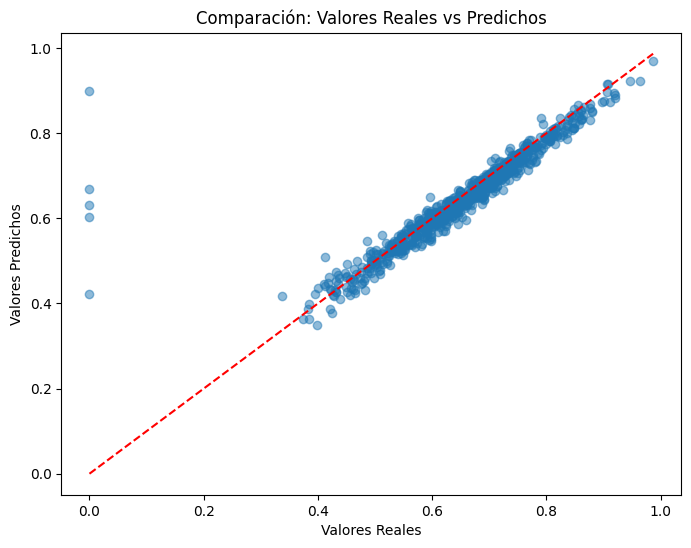

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación: Valores Reales vs Predichos')
plt.show()

### Validación Cruzada

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

lr_model = LinearRegression()


scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}


cv_results_train = cross_validate(lr_model, X_train, y_train, cv = 10, scoring = scoring)
cv_results_test = cross_validate(lr_model, X_test, y_test, cv = 10, scoring = scoring)


mean_r2_train = np.mean(cv_results_train['test_r2'])
mean_mse_train = -np.mean(cv_results_train['test_mse'])

print("Resultados de Validación Cruzada en conjunto de entrenamiento (K = 10 folds)")
print("R² Promedio:", mean_r2_train)
print("MSE Promedio:", mean_mse_train)


mean_r2_test = np.mean(cv_results_test['test_r2'])
mean_mse_test = -np.mean(cv_results_test['test_mse'])

print("\nResultados de Validación Cruzada en conjunto de prueba (K = 10 folds)")
print("R² Promedio:", mean_r2_test)
print("MSE Promedio:", mean_mse_test)

Resultados de Validación Cruzada en conjunto de entrenamiento (K = 10 folds)
R² Promedio: 0.6281497319543392
MSE Promedio: 0.007388943090936163

Resultados de Validación Cruzada en conjunto de prueba (K = 10 folds)
R² Promedio: 0.8172824576069445
MSE Promedio: 0.0033584239195320236


### Ajuste de Hiperparámetros

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]


cv = KFold(n_splits=10, shuffle=True, random_state=42)


param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}



grid_search = GridSearchCV(
    estimator = LinearRegression(),
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = cv,
    n_jobs = -1
)

grid_search.fit(X, y)

print("=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)

=== Grid Search ===
Mejores hiperparámetros encontrados: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Mejor Score (MSE negativo): -0.006188310184381708


### Validación Cruzada después del ajuste

In [ ]:

best_model = grid_search.best_estimator_


y_train_pred = cross_val_predict(best_model, X_train, y_train, cv = cv)
y_test_pred = cross_val_predict(best_model, X_test, y_test, cv = cv)


final_r2_train = r2_score(y_train, y_train_pred)
final_mse_train = mean_squared_error(y_train, y_train_pred)


final_r2_test = r2_score(y_test, y_test_pred)
final_mse_test = mean_squared_error(y_test, y_test_pred)

print("=== Evaluación Final del Modelo en el conjunto de entrenamiento ===")
print("R²:", final_r2_train)
print("MSE:", final_mse_train)

print("\n=== Evaluación Final del Modelo en el conjunto de prueba ===")
print("R²:", final_r2_test)
print("MSE:", final_mse_test)

=== Evaluación Final del Modelo en el conjunto de entrenamiento ===
R²: 0.6099230823818067
MSE: 0.00742070728126807

=== Evaluación Final del Modelo en el conjunto de prueba ===
R²: 0.7771075697171812
MSE: 0.0033852507229373786


## Decision Tree

### Antes de ajuste y validación cruzada

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 1.0
MSE: 0.0

Métricas en el conjunto de test:
R²: 0.5442620507522558
MSE: 0.007109361034956724


### Validación Cruzada

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

dt_model = DecisionTreeRegressor()


scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}


cv_results_train = cross_validate(dt_model, X_train, y_train, cv = 10, scoring = scoring)
cv_results_test = cross_validate(dt_model, X_test, y_test, cv = 10, scoring = scoring)


mean_r2_train = np.mean(cv_results_train['test_r2'])
mean_mse_train = -np.mean(cv_results_train['test_mse'])

print("Resultados de Validación Cruzada en conjunto de entrenamiento (K = 10 folds)")
print("R² Promedio:", mean_r2_train)
print("MSE Promedio:", mean_mse_train)


mean_r2_test = np.mean(cv_results_test['test_r2'])
mean_mse_test = -np.mean(cv_results_test['test_mse'])

print("\nResultados de Validación Cruzada en conjunto de prueba (K = 10 folds)")
print("R² Promedio:", mean_r2_test)
print("MSE Promedio:", mean_mse_test)

Resultados de Validación Cruzada en conjunto de entrenamiento (K = 10 folds)
R² Promedio: 0.5958908240919676
MSE Promedio: 0.00831350765367318

Resultados de Validación Cruzada en conjunto de prueba (K = 10 folds)
R² Promedio: 0.3489336777709399
MSE Promedio: 0.009088853958655078


### Ajuste de Hiperparámetros

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

cv = KFold(n_splits = 10, shuffle = True, random_state = 42)


param_distributions = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['best', 'random']
}

random_search = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(random_state = 42),
    param_distributions = param_distributions,
    n_iter = 10,
    scoring = 'neg_mean_squared_error',
    cv = cv,
    random_state = 42,
    n_jobs = -1
)

random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)


best_params = random_search.best_params_

max_depth_best = best_params['max_depth']
min_samples_split_best = best_params['min_samples_split']
min_samples_leaf_best = best_params['min_samples_leaf']
max_features_best = best_params['max_features']
criterion_best = best_params['criterion']
splitter_best = best_params['splitter']

param_grid = {
    'max_depth': [max(1, max_depth_best - 1), max_depth_best, max_depth_best + 1],
    'min_samples_split': [max(2, min_samples_split_best - 1), min_samples_split_best, min_samples_split_best + 1],
    'min_samples_leaf': [max(1, min_samples_leaf_best - 1), min_samples_leaf_best, min_samples_leaf_best + 1],
    'max_features': [max_features_best, 'sqrt', 'log2', None],
    'criterion': [criterion_best, 'squared_error', 'friedman_mse'],
    'splitter': [splitter_best, 'best', 'random']
}

grid_search = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state = 42),
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = cv,
    n_jobs = -1
)

grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

=== Randomized Search ===
Mejores hiperparámetros encontrados: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'friedman_mse'}
Mejor Score (MSE negativo): -0.007015669102696751

=== Grid Search ===
Mejores hiperparámetros encontrados: {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 11, 'splitter': 'random'}
Mejor Score (MSE negativo): -0.006803850624363608


### Validación Cruzada después del ajuste

In [ ]:

best_model = grid_search.best_estimator_


y_train_pred = cross_val_predict(best_model, X_train, y_train, cv = cv)
y_test_pred = cross_val_predict(best_model, X_test, y_test, cv = cv)


final_r2_train = r2_score(y_train, y_train_pred)
final_mse_train = mean_squared_error(y_train, y_train_pred)


final_r2_test = r2_score(y_test, y_test_pred)
final_mse_test = mean_squared_error(y_test, y_test_pred)

print("=== Evaluación Final del Modelo en el conjunto de entrenamiento ===")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\n=== Evaluación Final del Modelo en el conjunto de prueba ===")
print("R²:", r2_test)
print("MSE:", mse_test)

=== Evaluación Final del Modelo en el conjunto de entrenamiento ===
R²: 1.0
MSE: 0.0

=== Evaluación Final del Modelo en el conjunto de prueba ===
R²: 0.5442620507522558
MSE: 0.007109361034956724


## AdaBoost

### Test Train values

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost_model = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_model.fit(X_train, y_train)

y_train_pred = adaboost_model.predict(X_train)
y_test_pred = adaboost_model.predict(X_test)


r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

Métricas en el conjunto de entrenamiento:
R²: 0.614189184873227
MSE: 0.007058693477945319

Métricas en el conjunto de test:
R²: 0.605576191660522
MSE: 0.007654376414884104


### Cross-Validation

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

adaboost_model = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, random_state=42)

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error'
}

cv_results = cross_validate(adaboost_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)

Resultados de Validación Cruzada (K = 10 folds)
R² Promedio: 0.5306451190586456
MSE Promedio: 0.007720202361108075


### Ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]
cv = KFold(n_splits=10, shuffle=True, random_state=42)


param_distributions = {
    'n_estimators': np.arange(50, 501, 50),
    'learning_rate': np.linspace(0.01, 2, 50),
    'loss': ['linear', 'square', 'exponential']
}

random_search = RandomizedSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
n_estimators_best = best_params['n_estimators']
learning_rate_best = best_params['learning_rate']
loss_best = best_params['loss']

param_grid = {
    'n_estimators': [max(1, int(n_estimators_best * 0.5)), n_estimators_best, int(n_estimators_best * 1.5)],
    'learning_rate': [learning_rate_best * 0.5, learning_rate_best, learning_rate_best * 1.5],
    'loss': [loss_best]
}

grid_search = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)

KeyboardInterrupt: 

### Cross validation después del ajuste

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

best_model = grid_search.best_estimator_

y_pred = cross_val_predict(best_model, X, y, cv=cv)

final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)

### Test-train después del ajuste

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost_model = AdaBoostRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    loss=grid_search.best_params_['loss'],
    random_state=42
)


adaboost_model.fit(X_train, y_train)

y_train_pred = adaboost_model.predict(X_train)
y_test_pred = adaboost_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)

print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

## Bayesian Ridge

### Test Train values

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bayes_model = BayesianRidge()
bayes_model.fit(X_train, y_train)

y_train_pred = bayes_model.predict(X_train)
y_test_pred = bayes_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)

### Cross-Validation

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

bayes_model = BayesianRidge()

scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}

cv_results = cross_validate(bayes_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)

### Ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import BayesianRidge
import numpy as np

X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)

param_distributions = {
    'alpha_1': np.linspace(1e-7, 1e-5, 50),
    'alpha_2': np.linspace(1e-7, 1e-5, 50),
    'lambda_1': np.linspace(1e-7, 1e-5, 50),
    'lambda_2': np.linspace(1e-7, 1e-5, 50)
}

random_search = RandomizedSearchCV(
    estimator=BayesianRidge(),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
alpha_1_best = best_params['alpha_1']
alpha_2_best = best_params['alpha_2']
lambda_1_best = best_params['lambda_1']
lambda_2_best = best_params['lambda_2']

param_grid = {
    'alpha_1': [alpha_1_best * 0.5, alpha_1_best, alpha_1_best * 1.5],
    'alpha_2': [alpha_2_best * 0.5, alpha_2_best, alpha_2_best * 1.5],
    'lambda_1': [lambda_1_best * 0.5, lambda_1_best, lambda_1_best * 1.5],
    'lambda_2': [lambda_2_best * 0.5, lambda_2_best, lambda_2_best * 1.5]
}

grid_search = GridSearchCV(
    estimator=BayesianRidge(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_

y_pred = cross_val_predict(best_model, X, y, cv=cv)

final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bayes_model = BayesianRidge(
    alpha_1=grid_search.best_params_['alpha_1'],
    alpha_2=grid_search.best_params_['alpha_2'],
    lambda_1=grid_search.best_params_['lambda_1'],
    lambda_2=grid_search.best_params_['lambda_2']
)

bayes_model.fit(X_train, y_train)

y_train_pred = bayes_model.predict(X_train)
y_test_pred = bayes_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


## XG Boost

### Test Train values

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


### Cross-Validation

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

xgb_model = XGBRegressor(random_state=42)
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(xgb_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)


### Ajuste de hiperparámetros

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)

param_distributions = {
    'n_estimators': np.arange(50, 501, 50),
    'learning_rate': np.linspace(0.01, 0.3, 50),
    'max_depth': np.arange(3, 11)
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
n_estimators_best = best_params['n_estimators']
learning_rate_best = best_params['learning_rate']
max_depth_best = best_params['max_depth']

param_grid = {
    'n_estimators': [int(n_estimators_best * 0.5), n_estimators_best, int(n_estimators_best * 1.5)],
    'learning_rate': [learning_rate_best * 0.5, learning_rate_best, learning_rate_best * 1.5],
    'max_depth': [max(1, max_depth_best - 1), max_depth_best, max_depth_best + 1]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = XGBRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


## Neural Network

### Test Train values

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


### Cross-Validation

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

mlp_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(mlp_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)


### Ajuste de hiperparámetros

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)

param_distributions = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'alpha': np.linspace(1e-5, 1e-1, 50),
    'learning_rate_init': np.linspace(0.0001, 0.01, 50),
    'activation': ['relu', 'tanh']
}

random_search = RandomizedSearchCV(
    estimator=MLPRegressor(max_iter=500, solver='adam', random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
hidden_layer = best_params['hidden_layer_sizes']
alpha_best = best_params['alpha']
lr_best = best_params['learning_rate_init']
activation_best = best_params['activation']

hl_scaled_down = tuple(max(1, int(x * 0.5)) for x in hidden_layer)
hl_scaled_up = tuple(max(1, int(x * 1.5)) for x in hidden_layer)

param_grid = {
    'hidden_layer_sizes': [hl_scaled_down, hidden_layer, hl_scaled_up],
    'alpha': [alpha_best * 0.5, alpha_best, alpha_best * 1.5],
    'learning_rate_init': [lr_best * 0.5, lr_best, lr_best * 1.5],
    'activation': [activation_best]
}

grid_search = GridSearchCV(
    estimator=MLPRegressor(max_iter=500, solver='adam', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp_model = MLPRegressor(
    hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
    alpha=grid_search.best_params_['alpha'],
    learning_rate_init=grid_search.best_params_['learning_rate_init'],
    activation=grid_search.best_params_['activation'],
    max_iter=500,
    solver='adam',
    random_state=42
)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


## Ridge Regression

### Test Train values

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


### Cross-Validation

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

ridge_model = Ridge(random_state=42)
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(ridge_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)


### Ajuste de hiperparámetros

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)
param_distributions = {
    'alpha': np.logspace(-3, 3, 50),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

random_search = RandomizedSearchCV(
    estimator=Ridge(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
alpha_best = best_params['alpha']
solver_best = best_params['solver']

param_grid = {
    'alpha': [alpha_best * 0.5, alpha_best, alpha_best * 1.5],
    'solver': [solver_best]
}

grid_search = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_model = Ridge(
    alpha=grid_search.best_params_['alpha'],
    solver=grid_search.best_params_['solver'],
    random_state=42
)
ridge_model.fit(X_train, y_train)

y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


## Random Forest

### Test Train values

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


### Cross-Validation

In [ ]:
X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

rf_model = RandomForestRegressor(random_state=42)
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=scoring)

mean_r2 = np.mean(cv_results['test_r2'])
mean_mse = -np.mean(cv_results['test_mse'])

print("Resultados de Validación Cruzada (K = 10 folds)")
print("R² Promedio:", mean_r2)
print("MSE Promedio:", mean_mse)


### Ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
import numpy as np

X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

cv = KFold(n_splits=10, shuffle=True, random_state=42)
param_distributions = {
    'n_estimators': np.arange(50, 501, 50),
    'max_depth': [None] + list(np.arange(5, 21, 5)),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(1, 11, 1)
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X, y)

print("=== Randomized Search ===")
print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Score (MSE negativo):", random_search.best_score_)

best_params = random_search.best_params_
n_estimators_best = best_params['n_estimators']
max_depth_best = best_params['max_depth']
min_samples_split_best = best_params['min_samples_split']
min_samples_leaf_best = best_params['min_samples_leaf']

param_grid = {
    'n_estimators': [int(n_estimators_best * 0.5), n_estimators_best, int(n_estimators_best * 1.5)],
    'max_depth': [max_depth_best, max_depth_best + 5] if max_depth_best is not None else [None],
    'min_samples_split': [max(2, int(min_samples_split_best * 0.8)), min_samples_split_best, int(min_samples_split_best * 1.2)],
    'min_samples_leaf': [max(1, int(min_samples_leaf_best * 0.8)), min_samples_leaf_best, int(min_samples_leaf_best * 1.2)]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X, y)

print("\n=== Grid Search ===")
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor Score (MSE negativo):", grid_search.best_score_)


### Cross validation después del ajuste

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)

print("\n=== Evaluación Final del Modelo ===")
print("R²:", final_r2)
print("MSE:", final_mse)


### Test-train después del ajuste

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42
)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = df_ic.drop(columns=["ic_sbv_pob"])
y = df_ic["ic_sbv_pob"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    random_state=42
)
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Métricas en el conjunto de entrenamiento:")
print("R²:", r2_train)
print("MSE:", mse_train)
print("\nMétricas en el conjunto de test:")
print("R²:", r2_test)
print("MSE:", mse_test)
